<a href="https://colab.research.google.com/github/HowardHNguyen/Data_Science_for_Healthcare/blob/main/Framingham_(11627_records)_18_vs_24_Feature_Validation_for_v10_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predictive models aim to forecast the likelihood or timing of outcomes (e.g., cardiovascular disease, stroke) based on baseline data. The Framingham study is renowned for cardiovascular risk assessment, so predictors should be relevant to such outcomes. All baseline characteristics are potential predictors because they provide information about risk factors:

- 'SEX': Gender differences affect disease risk.
- 'AGE': Older age increases risk for many conditions.
- 'TOTCHOL', 'HDLC', 'LDLC': Cholesterol levels are key for heart disease prediction.
- 'SYSBP', 'DIABP': Blood pressure is a major cardiovascular risk factor.
- 'CURSMOKE', 'CIGPDAY': Smoking is a strong predictor of cardiovascular and other diseases.
- 'BMI': Obesity is linked to multiple health risks.
- 'DIABETES': A significant risk factor for cardiovascular events.
- 'BPMEDS': Indicates treated hypertension, affecting blood pressure interpretation.
- 'HEARTRTE': Resting heart rate reflects fitness and health.
- 'GLUCOSE': Elevated levels indicate metabolic issues.
- 'educ': Socioeconomic status influences health outcomes.
- 'PREVCHD', 'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP': Prior events strongly predict future events.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 24-FEATURE VALIDATION FOR V10.10
18-feature and 24-feature Framingham runs, covering:
- Discrimination: ROC AUC (+ PR AUC optional)
- Calibration: Brier score + calibration curve + calibration slope/intercept
- Threshold-based classification: metrics at clinically meaningful thresholds (e.g., 10% and 20%) + Youden-optimal threshold
- Outputs: clean tables + plots you can screenshot for v10.10 / investor diligence

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    roc_curve, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, balanced_accuracy_score
)
from sklearn.calibration import calibration_curve

In [6]:
data = pd.read_csv('frmgham2.csv')

features_18 = ['SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP','CIGPDAY', 'BMI', 'DIABETES', 'BPMEDS',
               'HEARTRTE', 'GLUCOSE', 'educ', 'HDLC', 'LDLC', 'ANGINA', 'MI_FCHD', 'STROKE', 'HYPERTEN']

features_24 = ['SEX','TOTCHOL','AGE','SYSBP','DIABP','CIGPDAY','BMI','DIABETES','BPMEDS','HEARTRTE',
               'GLUCOSE','educ','PREVCHD','PREVAP','PREVMI','PREVSTRK','PREVHYP','HOSPMI',
               'HDLC','LDLC','ANGINA','MI_FCHD','STROKE','HYPERTEN']
target = "CVD"

### Train/Test Split (Regulator-Safe)

In [7]:
def prepare_split(df, features, target):
    X = df[features]
    y = df[target].astype(int)

    return train_test_split(
        X, y,
        test_size=0.20,
        stratify=y,
        random_state=42
    )

### Baseline Model (Calibrated Logistic)

In [8]:
def build_logistic_model():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            solver="lbfgs"
        ))
    ])

## Tier-1 Evaluation Function

In [9]:
def tier1_eval(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    p = model.predict_proba(X_test)[:,1]

    # Discrimination
    auc = roc_auc_score(y_test, p)
    pr_auc = average_precision_score(y_test, p)

    # Calibration
    brier = brier_score_loss(y_test, p)
    frac_pos, mean_pred = calibration_curve(y_test, p, n_bins=10)

    # Calibration slope/intercept
    eps = 1e-6
    logit = np.log(np.clip(p, eps, 1-eps) / (1-np.clip(p, eps, 1-eps)))
    lr = LogisticRegression().fit(logit.reshape(-1,1), y_test)
    slope = lr.coef_[0][0]
    intercept = lr.intercept_[0]

    # Threshold metrics
    def at_thresh(t):
        yhat = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()
        return {
            "threshold": t,
            "accuracy": accuracy_score(y_test, yhat),
            "balanced_acc": balanced_accuracy_score(y_test, yhat),
            "precision": precision_score(y_test, yhat, zero_division=0),
            "recall": recall_score(y_test, yhat),
            "specificity": tn / (tn+fp),
            "f1": f1_score(y_test, yhat)
        }

    # Youden
    fpr, tpr, thr = roc_curve(y_test, p)
    youden_t = thr[np.argmax(tpr - fpr)]

    return {
        "ROC_AUC": auc,
        "PR_AUC": pr_auc,
        "Brier": brier,
        "Cal_slope": slope,
        "Cal_intercept": intercept,
        "Youden_threshold": youden_t,
        "Thresholds": pd.DataFrame([
            at_thresh(0.10),
            at_thresh(0.20),
            at_thresh(youden_t)
        ]),
        "Calibration_curve": (mean_pred, frac_pos)
    }

### Run 18-Feature Model

In [10]:
Xtr, Xte, ytr, yte = prepare_split(data, features_18, target)
model18 = build_logistic_model()
res18 = tier1_eval(model18, Xtr, Xte, ytr, yte)

res18["Thresholds"]

,threshold,accuracy,balanced_acc,precision,recall,specificity,f1
0,0.100000,0.755374,0.829572,0.504898,0.977586,0.681558,0.665884
1,0.200000,0.899828,0.913127,0.733513,0.939655,0.886598,0.823885
2,0.475795,0.952279,0.933671,0.910683,0.896552,0.970790,0.903562


### Run 24-Feature Model

In [11]:
Xtr, Xte, ytr, yte = prepare_split(data, features_24, target)
model24 = build_logistic_model()
res24 = tier1_eval(model24, Xtr, Xte, ytr, yte)

res24["Thresholds"]

,threshold,accuracy,balanced_acc,precision,recall,specificity,f1
0,0.100000,0.778160,0.843598,0.530019,0.974138,0.713058,0.686513
1,0.200000,0.911436,0.920859,0.761173,0.939655,0.902062,0.841049
2,0.492338,0.953998,0.936544,0.912740,0.901724,0.971363,0.907199


### Plot Calibration Curves (Lancet-Aligned)

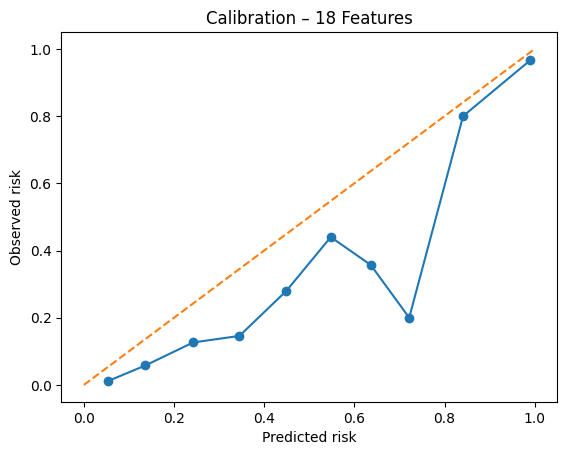

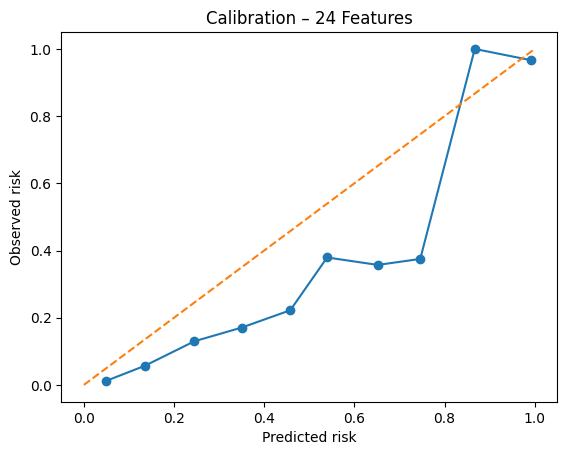

In [12]:
def plot_cal(res, title):
    mp, fp = res["Calibration_curve"]
    plt.figure()
    plt.plot(mp, fp, marker='o')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("Predicted risk")
    plt.ylabel("Observed risk")
    plt.title(title)
    plt.show()

plot_cal(res18, "Calibration – 18 Features")
plot_cal(res24, "Calibration – 24 Features")

In [13]:
from sklearn.ensemble import RandomForestClassifier

def build_baseline_model():
    return RandomForestClassifier(
        n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
    )

### End-to-end evaluation function (single split)

This produces Tier 1 outputs cleanly.

In [14]:
def evaluate_tier1(data, feature_cols, target_col, model, test_size=0.2, random_state=42):
    df = data[feature_cols + [target_col]].copy()

    X = df[feature_cols]
    y = df[target_col].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    p_test = pipe.predict_proba(X_test)[:, 1]

    # Discrimination
    auc = roc_auc_score(y_test, p_test)
    pr_auc = average_precision_score(y_test, p_test)

    # Calibration
    brier = brier_score_loss(y_test, p_test)
    slope, intercept = calibration_slope_intercept(y_test.values, p_test)

    # Calibration curve
    frac_pos, mean_pred = calibration_curve(y_test, p_test, n_bins=10, strategy="quantile")

    # Threshold-based metrics: clinical cutoffs + youden threshold
    t_youden, sens_y, spec_y = youden_optimal_threshold(y_test.values, p_test)
    thresh_list = [0.10, 0.20, float(t_youden)]

    threshold_rows = [metrics_at_threshold(y_test.values, p_test, t) for t in thresh_list]
    threshold_df = pd.DataFrame(threshold_rows)

    results = {
        "auc_roc": auc,
        "auc_pr": pr_auc,
        "brier": brier,
        "cal_slope": slope,
        "cal_intercept": intercept,
        "youden_threshold": float(t_youden),
        "cal_curve": (mean_pred, frac_pos),
        "threshold_table": threshold_df,
        "pipeline": pipe
    }
    return results

In [16]:
def calibration_slope_intercept(y_true, p_pred, eps=1e-6):
    p = np.clip(p_pred, eps, 1 - eps)
    logit = np.log(p / (1 - p))
    lr = LogisticRegression(solver="lbfgs")
    lr.fit(logit.reshape(-1, 1), y_true)
    slope = lr.coef_[0][0]
    intercept = lr.intercept_[0]
    return slope, intercept

In [18]:
def youden_optimal_threshold(y_true, p_pred):
    fpr, tpr, thresholds = roc_curve(y_true, p_pred)
    youden = tpr - fpr
    idx = np.argmax(youden)
    return thresholds[idx], tpr[idx], 1 - fpr[idx]

In [19]:
def metrics_at_threshold(y_true, p_pred, t):
    y_hat = (p_pred >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    precision = precision_score(y_true, y_hat, zero_division=0)
    recall = recall_score(y_true, y_hat, zero_division=0)  # sensitivity
    f1 = f1_score(y_true, y_hat, zero_division=0)
    acc = accuracy_score(y_true, y_hat)
    bal_acc = balanced_accuracy_score(y_true, y_hat)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    return {
        "threshold": t,
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "precision": precision,
        "recall_sensitivity": recall,
        "specificity": specificity,
        "f1": f1,
        "tp": tp, "fp": fp, "tn": tn, "fn": fn
    }

### Run for 18-feature and 24-feature models
If using baseline models (for pipeline validation):

In [20]:
res18 = evaluate_tier1(data, features_18, target, build_baseline_model())
res24 = evaluate_tier1(data, features_24, target, build_baseline_model())

print("18-feature ROC AUC:", res18["auc_roc"])
print("24-feature ROC AUC:", res24["auc_roc"])

18-feature ROC AUC: 0.9762466919461231
24-feature ROC AUC: 0.9785470237389896


### Plot: Calibration curves (Lancet-aligned)

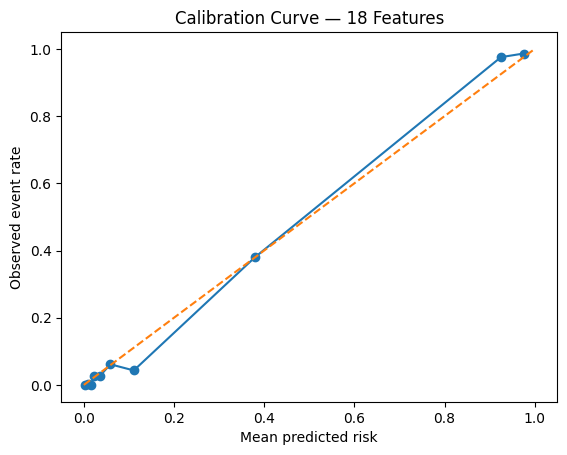

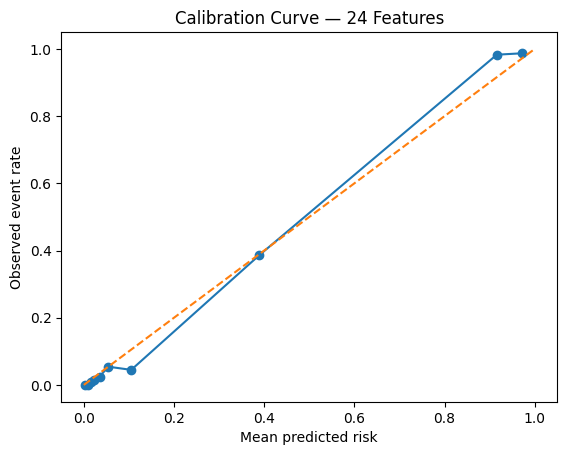

In [21]:
def plot_calibration(res, title):
    mean_pred, frac_pos = res["cal_curve"]

    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Mean predicted risk")
    plt.ylabel("Observed event rate")
    plt.title(title)
    plt.show()

plot_calibration(res18, "Calibration Curve — 18 Features")
plot_calibration(res24, "Calibration Curve — 24 Features")

### Print a clean “Tier 1 summary table” (great for diligence)

In [22]:
summary = pd.DataFrame([
    {
        "model": "18 features",
        "ROC AUC": res18["auc_roc"],
        "PR AUC": res18["auc_pr"],
        "Brier": res18["brier"],
        "Cal slope": res18["cal_slope"],
        "Cal intercept": res18["cal_intercept"],
        "Youden threshold": res18["youden_threshold"]
    },
    {
        "model": "24 features",
        "ROC AUC": res24["auc_roc"],
        "PR AUC": res24["auc_pr"],
        "Brier": res24["brier"],
        "Cal slope": res24["cal_slope"],
        "Cal intercept": res24["cal_intercept"],
        "Youden threshold": res24["youden_threshold"]
    }
])

summary

,model,ROC AUC,PR AUC,Brier,Cal slope,Cal intercept,Youden threshold
0,18 features,0.976247,0.951204,0.036489,1.227098,0.162753,0.286667
1,24 features,0.978547,0.957753,0.033750,1.265560,0.229804,0.256667


And the threshold tables:

In [23]:
print("18-feature threshold metrics:")
display(res18["threshold_table"])

print("24-feature threshold metrics:")
display(res24["threshold_table"])

18-feature threshold metrics:


,threshold,accuracy,balanced_accuracy,precision,recall_sensitivity,specificity,f1,tp,fp,tn,fn
0,0.100000,0.860275,0.889083,0.651246,0.946552,0.831615,0.771609,549,294,1452,31
1,0.200000,0.930782,0.930867,0.816944,0.931034,0.930699,0.870266,540,121,1625,40
2,0.286667,0.950559,0.934828,0.898799,0.903448,0.966208,0.901118,524,59,1687,56


24-feature threshold metrics:


,threshold,accuracy,balanced_accuracy,precision,recall_sensitivity,specificity,f1,tp,fp,tn,fn
0,0.100000,0.875322,0.901409,0.677696,0.953448,0.849370,0.792264,553,263,1483,27
1,0.200000,0.937661,0.935449,0.837209,0.931034,0.939863,0.881633,540,105,1641,40
2,0.256667,0.952709,0.941442,0.894295,0.918966,0.963918,0.906463,533,63,1683,47
